In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["svg.fonttype"]= "none"

In [ ]:
def process_data(df):
    nouveau_df = df.stack().reset_index()
    nouveau_df.columns = ['CT_1', 'CT_2', 'Fold_change']
    
        
    mask = ~nouveau_df['CT_1'].str.contains('L6 IT Car3', case=False) & \
           ~nouveau_df['CT_2'].str.contains('L6 IT Car3', case=False)

    nouveau_df = nouveau_df[mask]
    
    nouveau_df.reset_index(drop=True, inplace=True)
    
    return nouveau_df


## Remove duplicates:
def normalize_pair(a, b):
    a2, b2 = str(a), str(b)
    return tuple(sorted([a2, b2]))

In [ ]:
list_samples_aSTG = ["aSTG1", "aSTG2", "aSTG3"]
list_samples_pSTG = ["pSTG1", "pSTG3", "pSTG4", "pSTG5"]

specie = "human"

CGE_classes = ["Lamp5", "Vip", "Pax6", "Sncg"]
MGE_classes = ["Sst", "Pvalb", "Chandelier", "Lamp5 Lhx6"]

In [ ]:
def build_long_df(list_samples, subset_cell_types, layer):
    all_long = []
    for sample in list_samples:

        file_upper = pd.read_csv(f"{path/to/cell_information}/Fold_changes/{sample}/fold_change_{layer}.tsv", sep="\t")
        file_clean = process_data(file_upper)

        pairs = file_clean.apply(lambda r: normalize_pair(r["CT_1"], r["CT_2"]), axis=1)
        file_clean["pair_norm"] = pairs.map(lambda t: f"{t[0]}__{t[1]}")
        file_clean["sample"] = sample
        all_long.append(file_clean)

    long_df = pd.concat(all_long, ignore_index = True)
    long_df = long_df.drop_duplicates(subset=["pair_norm", "sample"], keep="first")
    long_df = long_df[
        (long_df["CT_1"].isin(subset_cell_types)) & 
        (long_df["CT_2"].isin(subset_cell_types))
    ]
    return long_df


def standard(df):
    df["Fold_change_z"] = (
    df["Fold_change"] - df["Fold_change"].mean()
) / df["Fold_change"].std()
    return df



def standard_max(df):
    df["Fold_change_z"] = df["Fold_change"] / df["Fold_change"].max()
    return df

In [ ]:
# Build both long dataframes
long_aSTG_CGE = build_long_df(list_samples_aSTG, subset_cell_types=CGE_classes, layer = "upper")
long_pSTG_CGE = build_long_df(list_samples_pSTG, subset_cell_types=CGE_classes, layer = "upper")
print(max(long_pSTG_CGE["Fold_change"]))
print(max(long_aSTG_CGE["Fold_change"]))

long_aSTG_CGE = standard(long_aSTG_CGE)
long_pSTG_CGE = standard(long_pSTG_CGE)

# Align visually
priority = ["Lamp5", "Pax6", "Sncg", "Vip"]
all_pairs = np.unique(pd.concat([long_aSTG_CGE.pair_norm, long_pSTG_CGE.pair_norm]).astype(str))

pair_order = [x for pref in priority for x in all_pairs if x.startswith(pref)]
print(pair_order)


# plotting
fig, axs = plt.subplots(1,2, figsize=(max(18, 0.35*len(pair_order)), 6), sharey=True)

sns.barplot(
    data=long_aSTG_CGE,
    x="pair_norm",
    y="Fold_change",
    hue="sample",
    order=pair_order,
    dodge=True,
    ax=axs[0]
)
axs[0].set_title("aSTG CGE")
axs[0].set_ylabel("Fold change")
axs[0].tick_params(axis='x', rotation=90)

sns.barplot(
    data=long_pSTG_CGE,
    x="pair_norm",
    y="Fold_change",
    hue="sample",
    order=pair_order,
    dodge=True,
    ax=axs[1]
)
axs[1].set_title("pSTG CGE")
axs[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


/tmp/ipykernel_2948610/4076788947.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_a = mat_a.applymap(lambda v: f"{v:.2f}" if pd.notna(v) and v > 0 else "")
/tmp/ipykernel_2948610/4076788947.py:12: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_p = mat_p.applymap(lambda v: f"{v:.2f}" if pd.notna(v) and v > 0 else "")


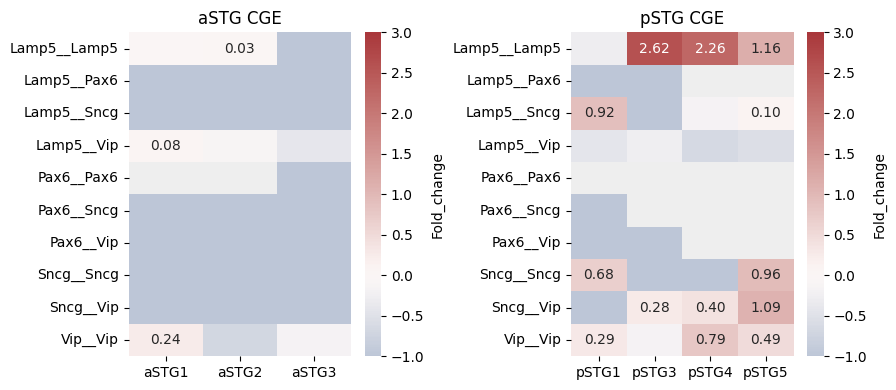

In [ ]:
# Pivots
mat_a = long_aSTG_CGE.pivot(index="pair_norm", columns="sample", values="Fold_change")
mat_p = long_pSTG_CGE.pivot(index="pair_norm", columns="sample", values="Fold_change")


union_idx = mat_a.index.union(mat_p.index)
mat_a = mat_a.reindex(union_idx)
mat_p = mat_p.reindex(union_idx)

annot_a = mat_a.applymap(lambda v: f"{v:.2f}" if pd.notna(v) and v > 0 else "") # Only display the fold change values for FC > 0
annot_p = mat_p.applymap(lambda v: f"{v:.2f}" if pd.notna(v) and v > 0 else "")


# Colormap --> Light grey for Nan
cmap = sns.color_palette("vlag", as_cmap=True)
cmap.set_bad(color="#eeeeee")

fig, axs = plt.subplots(1, 2, figsize=(max(9, 0.15*len(union_idx)), 4))

# --- aSTG ---
sns.heatmap(mat_a, cmap=cmap, center=0, vmin=-1, vmax=3, ax=axs[0], annot = annot_a, fmt = "",
            cbar_kws={"label": "Fold_change"})


axs[0].set_yticks(np.arange(mat_a.shape[0]) + 0.5) # Ticks positions : middle of the cells
axs[0].set_yticklabels(mat_a.index.tolist(), rotation=0)
axs[0].set_title("aSTG CGE")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

# --- pSTG ---
sns.heatmap(mat_p, cmap=cmap, center=0, vmin=-1, vmax=3, ax=axs[1], annot = annot_p, fmt = "",
            cbar_kws={"label": "Fold_change"})
axs[1].set_yticks(np.arange(mat_p.shape[0]) + 0.5)
axs[1].set_yticklabels(mat_p.index.tolist(), rotation=0)
axs[1].set_title("pSTG CGE")
axs[1].set_xlabel("")
axs[1].set_ylabel("")

plt.tight_layout()
plt.show()
